### Modelling and Forecasting Brent Crude Oil with Auto Regressive Integrated Moving Average (ARIMA)


**Importing Libraries**: The first section of the code imports necessary libraries for data manipulation, visualization, and time series analysis.


In [2]:
#%%
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


**Loading Data**: The data is loaded from a pre processed CSV file into a pandas DataFrame. The index of the DataFrame is set to be the date.


In [3]:
#%%

# Load data from csv file
data = pd.read_csv('Modified_Data.csv', index_col=[0], parse_dates=True)
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


The shape of the data shows the number of months and columns as (x,y)


In [4]:
data.shape

(252, 1)

**Plotting Data**: The data is plotted using `Plotly`, a Python graphing library. This provides a visual representation of the time series data.


In [5]:
# Plot data
fig = px.line(data, x=data.index, y='Price', title='Brent Crude Oil Prices')
fig.show()

**Checking Stationarity with Augmented Dickey-Fuller Test**: The Augmented Dickey-Fuller test is used to check if the time series is stationary. A stationary time series’ properties do not depend on the time at which the series is observed.


In [6]:
#%%

def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %f' % result[2])
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print(f"Data may be non-stationary, consider differencing")

print("""Testing stationarity of data:""")
adf_test(data)

Testing stationarity of data:
ADF Statistic: -2.883602
p-value: 0.047288
Number of lags used: 1.000000
Data is likely stationary.


**Decomposing Time Series**: Check for the components that make the series not stationary. The time series is decomposed into trend, seasonal, and residual components.


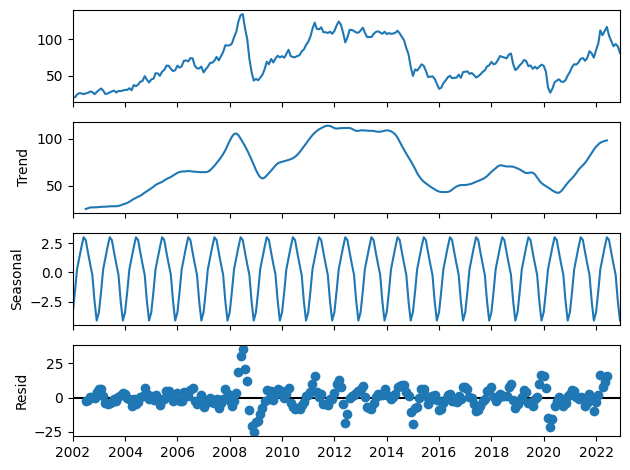

In [7]:
#%%

# Decompose time series into trend, seasonal, and residual components
result = seasonal_decompose(data, model='additive')
result.plot()
plt.show()

**Differencing to Make the Series Stationary**: Check for the number of differencing required to achieve stationarity. If the series is not stationary, it is differenced. Differencing is the transformation of the series to make it stationary.


In [8]:
# number of  differencing for stationary series with ndiffs

# Adf Test
print('ADF:', ndiffs(data, test='adf'))
# KPSS test
print('KPSS:', ndiffs(data, test='kpss'))
# PP test:
print('PP:', ndiffs(data, test='pp'))

ADF: 1
KPSS: 1
PP: 1


<Axes: title={'center': '1st Differencing'}>

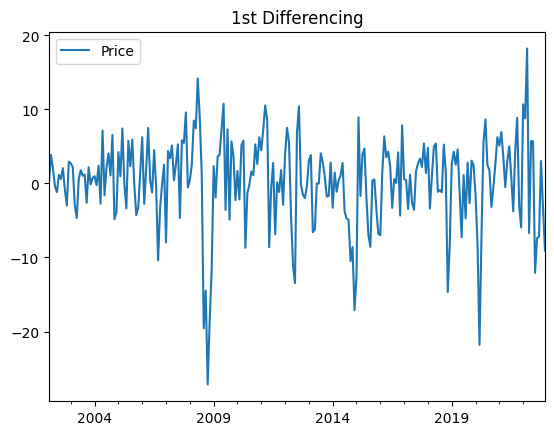

In [9]:
# Differencing to make the series stationary and plot the differenced series
diff = data.diff()[1:] # [1:] to remove NaN value

# plot and add legend in top right corner with plotly subplots
diff.plot(title="1st Differencing")


**Determining the Order of the AR and MA terms**: The Partial Autocorrelation Function `PACF` and the Autocorrelation Function `ACF` are plotted to determine the order of the `AR` and `MA` terms.


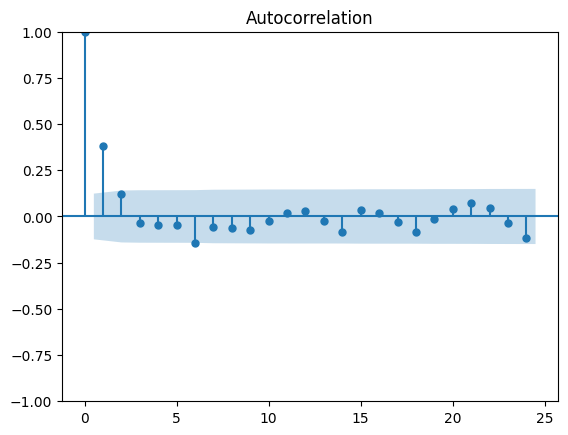

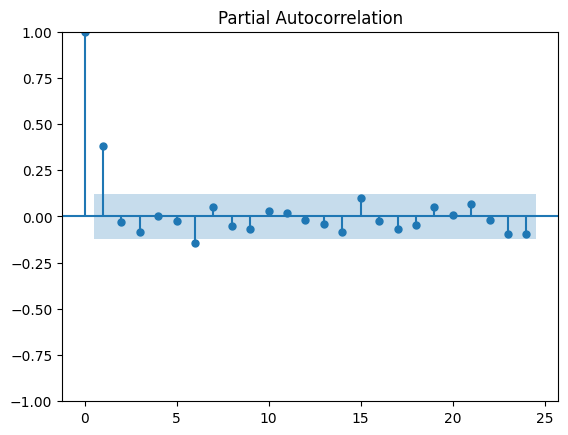

In [10]:
#%%
# Find order of MA term Q
plot_acf(diff).show()
# Order of auto regressive term P
plot_pacf(diff).show()

**Splitting Data into Train and Test Sets**:

- The data is split into training and testing sets based on a specified date.
- The training set is used to train the model, and
- The testing set is used to evaluate the model’s performance


In [11]:
#%%
# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


**Plotting Train and Test Splits**: The training and testing data are plotted to visualize the split.


In [12]:
# Plot train and test splits
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig.update_layout(title='Train and Test Split', xaxis_title='Date', yaxis_title='Price')
fig.show()

**Model Selection with Information Criteria Approach**: The auto_arima function is used to automatically select the best `ARIMA` model based on the **Akaike Information Criterion** `AIC`.


In [13]:
# use auto_arima to find best parameters
model = pm.auto_arima(data, seasonal=True, stepwise=True, suppress_warnings=True, trace=True, error_action="ignore")
print(f"ARIMA Order: {model.order}")
print(f"Seasonal Order: {model.seasonal_order}")
print(f"AIC: {model.aic()}")
print(f"BIC: {model.bic()}")
print(f"HQIC: {model.hqic()}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1578.236, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1612.420, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1575.066, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1579.935, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1610.842, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1576.870, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1576.932, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1575.145, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1573.222, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1575.037, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1575.095, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1578.181, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1573.727, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.502 seconds
ARIMA Order: (1, 1, 0)

**Model Diagnostics**: The residuals of the model are checked to ensure that the assumptions of the model are met.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -784.611
Date:                Sun, 19 May 2024   AIC                           1573.222
Time:                        10:37:04   BIC                           1580.273
Sample:                    01-01-2002   HQIC                          1576.060
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3831      0.043      8.923      0.000       0.299       0.467
sigma2        30.3674      2.072     14.656      0.000      26.306      34.429
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                47.35
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.71
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

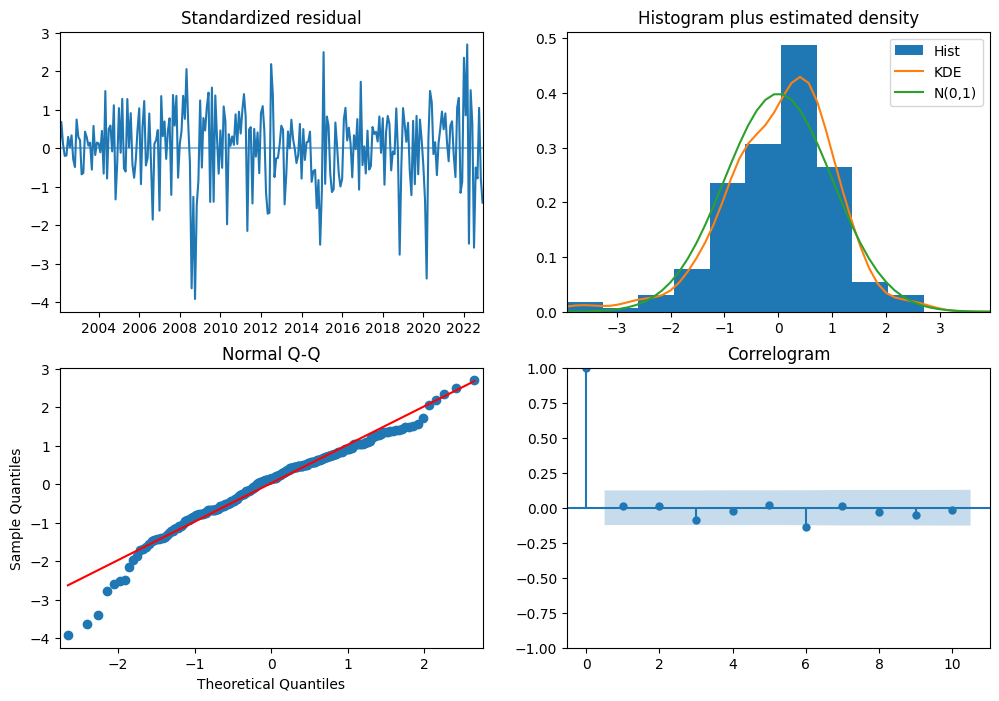

In [14]:
#%%
model.plot_diagnostics(figsize=(12, 8)).show()
model.summary()

- **Standardized Residuals**: Fluctuations around the zero line suggest that the residuals do not exhibit any clear patterns over time, which is a good sign.
- **Histogram and Density**: The histogram of standardized residuals should resemble the overlaid normal distribution curve (N(0,1)), indicating normality.
- **Q-Q Plot**: The quantiles of the residuals should lie approximately along the reference line if they are normally distributed.
- **Residuals vs Fitted**: No obvious pattern or systematic deviation from zero would imply that the residuals have constant variance.

These diagnostics help ensure that the residuals are normally distributed and homoscedastic (having constant variance), which are important assumptions for the validity of an ARIMA model. If these assumptions are violated, it may affect the model's predictions and inferences. Remember to also consider other model diagnostics such as the ACF/PACF plots and statistical tests for further validation.

**Model Fitting**: The model is fitted to the training data.


In [15]:
#%%
# Fit the model with the rraining set and best parameters found by auto_arima 
model = SARIMAX(train, order= model.order)
model_fit = model.fit()
# residuals = model_fit.resid

# Print the summary of the model
model_fit.summary(alpha=0.05) # 95% confidence interval
model_fit.summary(alpha=0.20) # 80% confidence interval 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -624.444
Date:                Sun, 19 May 2024   AIC                           1252.888
Time:                        10:37:06   BIC                           1259.514
Sample:                    01-01-2002   HQIC                          1255.568
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|        [0.1        0.9]
------------------------------------------------------------------------------
ar.L1          0.4152      0.047      8.894      0.000       0.355       0.475
sigma2        27.4768      2.023     13.585      0.000      24.885      30.069
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.74
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Prediction**: The model is used to make predictions on the test data.


In [16]:
test.head()

,Price
2019-01-01,60.23
2019-02-01,64.50
2019-03-01,67.05
2019-04-01,71.66
2019-05-01,70.30


In [17]:
# dynamic=False means that forecasts at each point are generated using the full history up to that point
predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
residuals = test['Price'] - predictions

In [18]:
predictions.tail()

2022-08-01    51.783188
2022-09-01    51.783188
2022-10-01    51.783188
2022-11-01    51.783188
2022-12-01    51.783188
Freq: MS, Name: predicted_mean, dtype: float64

**Model Evaluation**: The model’s performance is evaluated using the **Root Mean Squared Error** `RMSE`, **Mean Absolute Error** `MAE`, and **Mean Absolute Percentage Error** `MAPE`.


In [19]:
#%%

# Calculate evaluation metrics
print(""" Error Metrics """)

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
directional_accuracy = np.mean(np.sign(test['Price'].diff().dropna()) == np.sign(predictions.diff().dropna()))


print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Percentage Error: {mape*100:.3f}%')
print(f'Directional Accuracy: {directional_accuracy*100:.3f}%')

 Error Metrics 
Mean Squared Error: 769.664
Mean Absolute Error: 22.322
Root Mean Squared Error: 27.743
Mean Absolute Percentage Error: 30.476%
Directional Accuracy: 31.915%


**Explain the Metrics:**

  * **Mean Squared Error (MSE):**  This measures the average squared difference between the predicted and actual values. A lower MSE indicates a better fit.
  * **Mean Absolute Error (MAE):** This measures the average of the absolute differences between predicted and actual values. A lower MAE indicates a better fit. 
  * **Root Mean Squared Error (RMSE):**  This is the square root of the MSE. It's easier to interpret in the same units as your data (USD in this case). A lower RMSE indicates a better fit.
  * **Mean Absolute Percentage Error (MAPE):** This measures the average absolute percentage difference between predicted and actual values. A lower MAPE indicates a better fit, but it can be misleading for large values. 
  * **Directional Accuracy:** This metric (not as common as others) tells you the percentage of times the forecast correctly predicted the direction of the price change (up or down).

In [42]:
# Create a list of error metric names and values
from matplotlib import legend


metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'DA']
values = np.array([mse, rmse, mae, mape, directional_accuracy])

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Error Metrics', x=metrics, y=values, 
           marker_color=['red', 'lightgreen', 'orange', 'pink', 'purple'],
           text=values.round(2),  # Add values on top of each bar
           textposition='auto')  # Position of the text
])

# Customize aspect
fig.update_layout(title_text='Error Metrics Comparison',
                  xaxis_title="Error Metrics",
                  yaxis_title="Value",
                  autosize=False,
                  width=800,
                  height=600,
                  margin=dict(l=50, r=50, b=100, t=100, pad=4),
                  legend
                  legend=dict(x=0.7, y=0.95),  # Position of the legend
                  yaxis_type="log")  # Set y-axis to logarithmic scale

# Display the chart
fig.show()

**Plotting Actual vs Predicted Prices**: The actual and predicted prices are plotted.


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()


**Forecasting Future Prices**: The model is used to forecast future prices.


In [ ]:
# Forecasting with confidence intervals for the next 24 months

future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M') 

# Forecast with 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# Forecast with 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot the forecast with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))
fig.update_layout(title='Brent Crude Oil Price Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Price')
fig.show()